# The gradient regularized asymptotic correction.
## I. The ionization potenital issue

Often with density functional theory one would like to do something interesting with the resulting wavefunction; however a number of issues exsist with convention DFT computations.

Let us first compute Ionization Potential at several different levels of the theory and then compare the results to the NIST database (http://physics.nist.gov).

In [1]:
import psi4
import numpy as np
import ks_helper as ks
import matplotlib.pyplot as plt
%matplotlib inline

mol = psi4.geometry("""
Ne
symmetry c1
""")
options = {'BASIS':     'aug-cc-pVDZ',
           'NAT_ORBS':  True,
           'NUM_ROOTS': 2,
           'QC_MODULE': 'DETCI'}
psi4.set_options(options)

scf_e, scf_wfn = psi4.energy("SCF", return_wfn=True)
scf_e, dft_wfn = psi4.energy("PBE0", return_wfn=True)
scf_e, ci_wfn =  psi4.energy("CISD", return_wfn=True)

Now that we have the Wavefunctions we can then compute the ionization potenital. For SCF theories this is the the energy of the HOMO while for more advanced theories, it is the differente between the ground and excited states. We can obtain the IP for each level of theory in the following way:

In [2]:
scf_ip = -1 * scf_wfn.epsilon_a()[scf_wfn.nalpha()-1] * psi4.p4const.psi_hartree2ev
dft_ip = -1 * dft_wfn.epsilon_a()[dft_wfn.nalpha()-1] * psi4.p4const.psi_hartree2ev
ci_ip = -1 * (psi4.core.get_variable("CI ROOT 0 TOTAL ENERGY") - psi4.core.get_variable("CI ROOT 1 TOTAL ENERGY")) * psi4.p4const.psi_hartree2ev

print("Neon Ionization Potential (eV)")
print("SCF     %10.4f" % scf_ip)
print("PBE0    %10.4f" % dft_ip)
print("CISD    %10.4f" % ci_ip)
print("NIST    %10.4f" % 21.5645)

Neon Ionization Potential (eV)
SCF        23.2125
PBE0       16.0337
CISD       22.2776
NIST       21.5645


## I. Density shapes
If we think carefully about the ionization potenital and what this really means it can be summed up susinctly as "How hard is it for the electron to leave the system" or "How deep is our potenital well"? A easy way to view the shape of the potenital for a given method is to inspect the density as a function of spatial extent. A weaker potential would mean that the density extends further than it should and our IP would be too small. While a stronger potenital would mean that the density is more concentrated and the IP is too large. As we only have a single atom we can project our density into grid space and then sort the results as a function of distance from the nucleous. 

In [3]:
def one_electron_radial(matrices, Vpot):
    """
    For every matrix in matrices, computes the radial density using the incoming Vpot object.
    """
    
    results = [[] for x in matrices]
    Rlist = []
    
    points_func = Vpot.properties()[0]
    superfunc = Vpot.functional()

    xc_e = 0.0
    vv10_e = 0.0
    
    # First loop over the outer set of blocks
    for block in range(Vpot.nblocks()):
        
        # Obtain general grid information
        grid = Vpot.get_block(block)
        x = np.array(grid.x())
        y = np.array(grid.y())
        z = np.array(grid.z())
        npoints = z.shape[0]

        # Get radial information
        R = ((x ** 2) + (y ** 2) + (z ** 2)) ** 0.5
        Rlist.append(R)
        
        # Loop over and compute the density for each matrix
        for num, mat in enumerate(matrices):
            points_func.set_pointers(mat)
            points_func.compute_points(grid)
            results[num].append(np.array(points_func.point_values()["RHO_A"])[:npoints])
       
    # Stack R
    Rlist = np.hstack(Rlist)
    
    # Get the R unique and sort
    unique, uidx = np.unique(Rlist, return_index=True)
    Rlist = Rlist[uidx]
    
    # Numpy is magic, it would be worthwhile to consider excatly what this does
    results = [np.hstack(x)[uidx] for x in results]

    return (Rlist, results)

# Compute the radial densities
sup = psi4.driver.dft_funcs.build_superfunctional("SVWN", True)[0]
Vpot = psi4.core.VBase.build(scf_wfn.basisset(), sup, "RV")
Vpot.initialize()

R, data = one_electron_radial([scf_wfn.Da(), dft_wfn.Da(), ci_wfn.Da()], Vpot)

Now that we have the radial densities, we build  a function that will plot the density as a ratio between
the method a benchmark. Here we will select the CISD densities as the benchmark and plot the SCF and DFT quanties against them.

In [33]:
def plot_scatter_ratio(dictionary, bench, x_values):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    
    for k, v in dictionary.items():
        ax1.plot(x_values, v / bench, label=k)
        
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 7)
    ax1.set_xlabel('R')
    ax1.set_ylabel('rho(r) / rho(r)_bench')
    
    plt.plot([0, 7], [1.0, 1.0], 'k-')

Plotting this data we note that the SCF density falls off too rapidly, meaning that potential is too deep while the DFT density falls off far too slowly indicating the potenital is too shallow. For example many theories examine the overlap between densities. From this chart we can surmise issues that would arise with both DFT and HF theories.

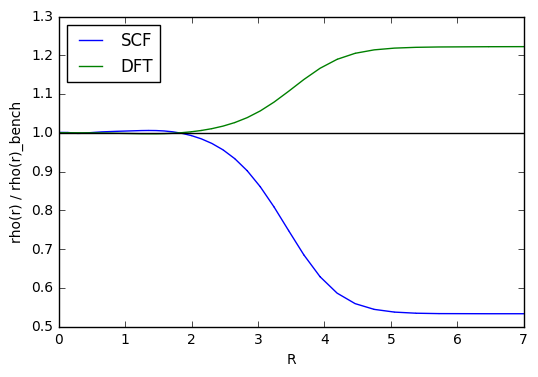

In [34]:
data_dict = {"SCF": data[0], "DFT": data[1]}
plot_scatter_ratio(data_dict, data[2], R)

## 2. The GRAC Correction
The question then arises, what if we could correct the DFT potential asymptotic so that it recovers the correct density and therefore the correction ionization potenital. Effectively we want to accomplish:

$$v_{\rm{xc}}({\bf r}) = -\frac{1}{r} + v_{\rm{xc}}(\infty)$$

However, for correct asympotics this would require the exact $v_{\rm{xc}}$ potenital. As we operate completely in the Density Funcitonal Approximation domain, this is not a possible task. Instead, the GRAC correction requires that we know our Ionization Potential and we can replace the complex DFT term with the following:

$$v_{\rm{xc}}({\bf r}) = -\frac{1}{r} + (I_{\bf P} + \epsilon_N)$$

Where $\epsilon_N$ is our HOMO energy. This is quite clever as we now only need a functional that correctly goes to the $\frac{1}{r}$ asymptotic. As no general functional accomplishes this task a special functional, "LB94", was built with exactly this property. The downside is that this functionals characteristics are quite poor in the "bulk" region or the region near the atom itself. To generalize this a switching function is introduced:

$$
\begin{align}
v_{\rm{xc}}^{GRAC}(\rho({\bf r})) &= [1 - f[x({\bf r})]]v_{\rm{XC}}^{\rm bulk}+ f[x({\bf r})]v_{\rm{XC}}^{\rm Asym.}  \\ \\
f[x({\bf r})] &= \frac{1}{1 + e^{-\alpha[x({\bf r}) - \beta]}}\\\\
x({\bf r}) &= \frac{| \nabla \rho({\bf r}) | }{\rho^\frac{4}{3}({\bf r})}
\end{align}
$$


Thus, in such a way we seemlessly switch between the bulk and asymptotic potenitals. In addition, such a formulation allows us to apply the GRAC correction to any underlying functional in a general way.


In [13]:
# Build a LB 94 functional
lb94_func = psi4.core.SuperFunctional.blank()
lb94_func.set_max_points(500000)
lb94_func.set_deriv(1)

# Add member functionals
tmp_func = psi4.core.LibXCFunctional('XC_GGA_X_LB', True)
# We need to scale this for the amount of exact exchange is in the functional
tmp_func.set_alpha(0.75)
lb94_func.add_x_functional(tmp_func)

# Dont forget VWN correlation!
tmp_func = psi4.core.LibXCFunctional('XC_LDA_C_VWN', True)
lb94_func.add_c_functional(tmp_func)

# Allocate the functional
lb94_func.allocate()

grac_shift = (21.5645 - dft_ip) /  psi4.p4const.psi_hartree2ev

def compute_V_GRAC(D, Vpot):
    """
    Computes the XC energy and the V_xc Fock term
    """
    
    grac_alpha = 0.5
    grac_beta = 40.0

    nbf = D.shape[0]
    Varr = np.zeros((nbf, nbf))

    points_func = Vpot.properties()[0]
    superfunc = Vpot.functional()
    
    total_e = 0.0
    
    for x in range(Vpot.nblocks()):

        # Grid data
        grid = Vpot.get_block(x)
        w = np.array(grid.w())
        npoints = w.shape[0]

        points_func.compute_points(grid)
        lpos = np.array(grid.functions_local_to_global())
        nfunctions = lpos.shape[0]
        
        phi = np.array(points_func.basis_values()["PHI"])[:npoints, :nfunctions]
        
        rho = np.array(points_func.point_values()["RHO_A"])[:npoints]
        gamma = np.array(points_func.point_values()["GAMMA_AA"])[:npoints]

        grac_x = (gamma ** 0.5) / (rho ** (4.0/3.0))
        grac_fx = 1.0 / (1.0 + np.exp(-grac_alpha * (grac_x - grac_beta)))
        
        ret = superfunc.compute_functional(points_func.point_values(), -1)
        lbret = lb94_func.compute_functional(points_func.point_values(), -1)
        
        total_e += np.vdot(np.array(ret["V"])[:npoints], w)
        
        v_rho_a  = ( 1 - grac_fx ) * (np.array(ret["V_RHO_A"])[:npoints] - grac_shift)
        v_rho_a += grac_fx * np.array(lbret["V_RHO_A"])[:npoints]
        v_rho_a *= 0.5 * w
        
        Vtmp = np.einsum('pb,p,pa->ab', phi, v_rho_a, phi)

        # GGA
        rho_x = np.array(points_func.point_values()["RHO_AX"])[:npoints]
        rho_y = np.array(points_func.point_values()["RHO_AY"])[:npoints]
        rho_z = np.array(points_func.point_values()["RHO_AZ"])[:npoints]
        
        phi_x = np.array(points_func.basis_values()["PHI_X"])[:npoints, :nfunctions]
        phi_y = np.array(points_func.basis_values()["PHI_Y"])[:npoints, :nfunctions]
        phi_z = np.array(points_func.basis_values()["PHI_Z"])[:npoints, :nfunctions]
        
        v_gamma  = (1 - grac_fx) * np.array(ret["V_GAMMA_AA"])[:npoints]
        v_gamma *= 2.0 * w
        Vtmp += np.einsum('pb,p,p,pa->ab', phi, v_gamma, rho_x, phi_x)
        Vtmp += np.einsum('pb,p,p,pa->ab', phi, v_gamma, rho_y, phi_y)
        Vtmp += np.einsum('pb,p,p,pa->ab', phi, v_gamma, rho_z, phi_z)

        
        Varr[(lpos[:, None], lpos)] += Vtmp + Vtmp.T

    return total_e, Varr

# Test our function the the handy ks solver.
grac_e, grac_data = ks.ks_solver("PBE0", mol, options, compute_V_GRAC)       


Number of occupied orbitals: 5
Number of basis functions:   23

Total time taken for setup: 0.104 seconds

Starting SCF iterations:

    Iter            Energy             XC E         Delta E        D RMS

SCF Iter  1: -122.77276496638299   -11.5514811   -1.22773E+02   1.54636E-01
SCF Iter  2: -117.91648102465675    -6.5084631    4.85628E+00   1.92640E-01
SCF Iter  3: -128.74463947688568    -9.6261545   -1.08282E+01   2.12715E-02
SCF Iter  4: -128.81102425572726    -9.4609713   -6.63848E-02   8.13447E-03
SCF Iter  5: -128.82008389738900    -9.3869302   -9.05964E-03   1.40492E-03
SCF Iter  6: -128.82045508576886    -9.3712711   -3.71188E-04   7.47537E-06
SCF Iter  7: -128.82045611606000    -9.3713195   -1.03029E-06   5.90707E-07
SCF Iter  8: -128.82045610026913    -9.3713253    1.57909E-08   2.69714E-08

Total time for SCF iterations: 5.743 seconds 

Final SCF energy: -128.82045610 hartree


We can now check against the Psi4 reference implementation. Note that we set the GRAC shift on either side of the computation so that we do not contaminate other computations.

In [8]:
psi4.set_options({"dft_grac_shift": grac_shift})
print(psi4.energy("PBE0"))
psi4.set_options({"dft_grac_shift": 0.0})

-128.82045597323582


## 3. Inspecting the outcome
Now that we applied the GRAC shift we can observe the density and see how well we do.

In [25]:
grac_ip = -1 * grac_data["eigenvalues"][dft_wfn.nalpha()-1] * psi4.p4const.psi_hartree2ev

print("Neon Ionization Potential (eV)")
print("SCF     %10.4f" % scf_ip)
print("PBE0    %10.4f" % dft_ip)
print("PBE0-AC %10.4f" % grac_ip)
print("CISD    %10.4f" % ci_ip)
print("NIST    %10.4f" % 21.5645)

Neon Ionization Potential (eV)
SCF        23.2125
PBE0       16.0337
PBE0-AC    21.4447
CISD       22.2776
NIST       21.5645


We observe that our ionization potenital is now much closer to the correct ionization potenital and while the density is not perfect, it is much closer to the CISD density.

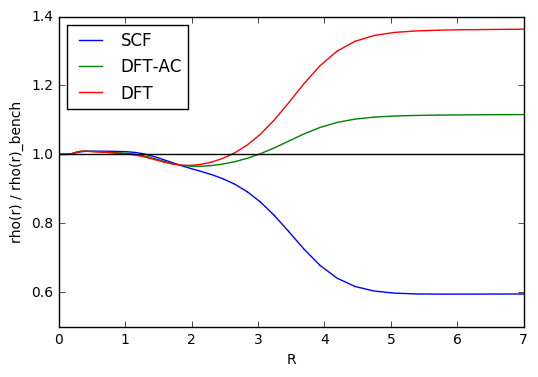

In [35]:
R, data = one_electron_radial([scf_wfn.Da(), dft_wfn.Da(), grac_data["Da"], ci_wfn.Da()], Vpot)
data_dict = {"SCF": data[0], "DFT": data[1], "DFT-AC": data[2]}
plot_scatter_ratio(data_dict, data[3], R)

Refs:
 - M. Gruning, O. V. Gritsenko, S. J. A. van Gisbergen, and E. J. BaerendsJ. Chem. Phys., **2001**, *114*, 652